In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns

import scipy.stats as stats
from scipy.stats.mstats import winsorize
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from scipy.stats import boxcox
import string

from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

In [3]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'studentsperformance'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

student_df = pd.read_sql_query('select * from studentsperformance',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [4]:
student_df.describe(include='all')

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
count,1000,1000,1000,1000,1000,1000.00000,1000.000000,1000.000000
unique,2,5,6,2,2,NaN,NaN,NaN
top,female,group C,some college,standard,none,NaN,NaN,NaN
freq,518,319,226,645,642,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,66.08900,69.169000,68.054000
std,NaN,NaN,NaN,NaN,NaN,15.16308,14.600192,15.195657
min,NaN,NaN,NaN,NaN,NaN,0.00000,17.000000,10.000000
25%,NaN,NaN,NaN,NaN,NaN,57.00000,59.000000,57.750000
50%,NaN,NaN,NaN,NaN,NaN,66.00000,70.000000,69.000000
75%,NaN,NaN,NaN,NaN,NaN,77.00000,79.000000,79.000000


In [5]:
student_df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


## Data cleanup

Math score has a 0 in its set, index==59. This makes Box-Cox bomb, because all values must be > 0.
Let's transform this value to something super tiny that's close to, but > 0.

In [6]:
#student_df.loc[student_df['math score'] == 0]
student_df['math score'] = student_df['math score'].apply(lambda x: .0001 if x == 0 else x)
student_df.iloc[59]

gender                                   female
race/ethnicity                          group C
parental level of education    some high school
lunch                              free/reduced
test preparation course                    none
math score                               0.0001
reading score                                17
writing score                                10
Name: 59, dtype: object

# Functions

In [7]:
def scores_distplot(series1,series2,series3):
    plt.figure(figsize=(15,5))
    plt.suptitle("Exam scores distribution")

    ax1 = plt.subplot(1,3,1)
    sns.distplot(series1)
    ax1.set_xlabel("Math score")

    ax2 = plt.subplot(1,3,2)
    sns.distplot(series2)
    ax2.set_xlabel("Reading score")
                   
    ax3 = plt.subplot(1,3,3)
    sns.distplot(series3)
    ax3.set_xlabel("Writing score")
                   
    plt.show()

In [8]:
def is_it_normal(series):
#    jb_stats = jarque_bera(series)
    norm_stats = normaltest(series)
#    print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
    print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

In [53]:
def barplot_comparison(df,y_col,x_list,**kwargs):
    nostats = kwargs.get('nostats',False)
    plt.figure(figsize=(15,5))
    plt.suptitle("Comparing {} by {}".format(string.capwords(', '.join(x_list)),
                                             string.capwords(y_col)),
                 fontsize=16)
    num_subplots = len(x_list)
    for subplot, score in enumerate(x_list,1):
        ax = plt.subplot(1,num_subplots,subplot)
        g=sns.barplot(x=score,
                    y=y_col,
                    data=df)
    plt.tight_layout()
    plt.show()
    all_cols = x_list.insert(0,y_col)
    grouped_values = df[x_list].groupby(y_col)
    if (nostats != True):
        print(grouped_values.describe())

# Assignment

## 1. Are the exam score variables normally distributed? If not, apply a Box-Cox transformation. Does anything change?

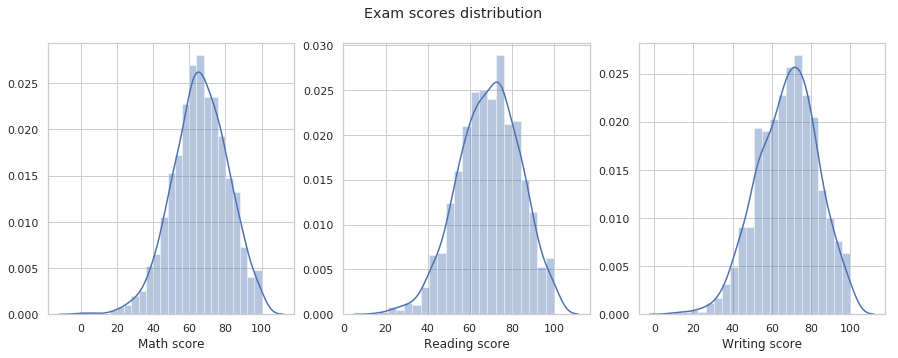

In [10]:
scores_distplot(student_df['math score'],
                student_df['reading score'],
                student_df['writing score'])

These look sorta close to normal. As in the lesson, I can check this using the ~~Jarque-Bera and~~ Normal tests.

If I [read correctly](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.jarque_bera.html), Jarque-Bera is only really good for samples of > 2000 records, and we only have 1000 in this dataset. [The page for the Normal test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html) doesn't mention any such restriction.

In [11]:
is_it_normal(student_df['math score'])

Normality test statistics is 15.408900559147664 and p value is 0.00045081645279838005


In [12]:
is_it_normal(student_df['reading score'])

Normality test statistics is 11.11741279628622 and p value is 0.003853758403576582


In [13]:
is_it_normal(student_df['writing score'])

Normality test statistics is 13.606450837263859 and p value is 0.0011101885439899974


__These results (the low p-values in particular) suggest these distributions are not normal. So, let's try applying the Box Cox transformation to these variables and try again:__

In [14]:
boxcox_math,_ = boxcox(student_df['math score'])
boxcox_reading,_ = boxcox(student_df['reading score'])
boxcox_writing,_ = boxcox(student_df['writing score'])

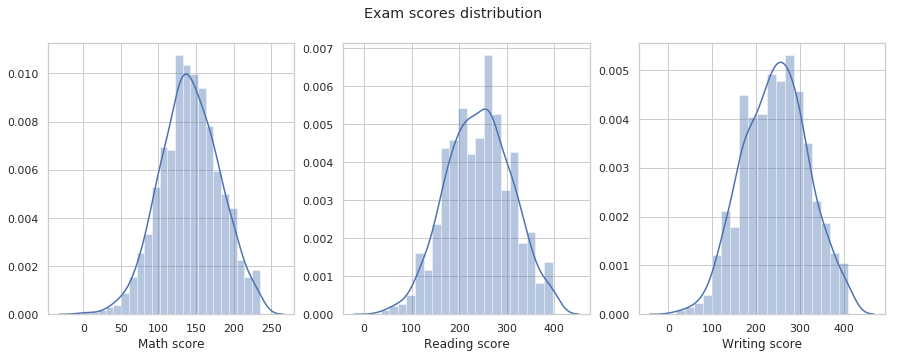

In [15]:
scores_distplot(boxcox_math,
                boxcox_reading,
                boxcox_writing)

In [16]:
is_it_normal(boxcox_math)

Normality test statistics is 1.2909595413645605 and p value is 0.5244108847745317


In [17]:
is_it_normal(boxcox_reading)

Normality test statistics is 5.282274611852865 and p value is 0.07128015609575467


In [18]:
is_it_normal(boxcox_writing)

Normality test statistics is 6.267311355043339 and p value is 0.04355827085023795


...Better? The distribution for math score looks pretty good now--if these values are the same as those for t-tests, the Box-Cox treated math scores are now just over 1 standard deviation away from a normal curve, with a p-value of .5244. That sounds pretty good. The transformed reading and writing score distributions are better, but still not that great.

## 2. Say we want to use a single variable for the exam scores as our target. For this purpose, create a new variable by taking a weighted average of the exam scores. Check whether this new variable is normally distributed. If it's not normally distributed, apply a Box-Cox transformation and check whether or not the transformed variable is normally distributed.

__NOTE:__ I honestly stumbled on how to calculate a "weighted average" for this question. After reading up on how to calculate a weighted average, I did not understand what we should use to assign weights to the three scores for each row in the dataset. I had to look at the sample solution, where I see that there are no weights whatsoever, just a mean of the three scores. Okay then.

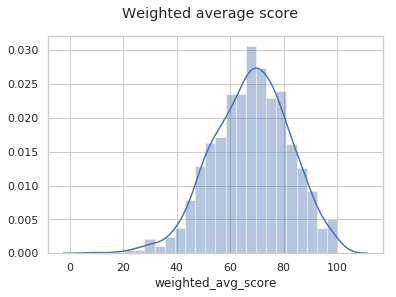

In [25]:
student_df['weighted_avg_score'] = (student_df['math score'] \
                                   + student_df['reading score'] \
                                   + student_df['writing score'])/3

plt.suptitle("Weighted average score")
sns.distplot(student_df['weighted_avg_score'])
plt.show()

In [26]:
is_it_normal(student_df['weighted_avg_score'])

Normality test statistics is 15.186706399505262 and p value is 0.0005037889136468627


This sort of looks normal, but the Normal test says it is not.

__Box-Cox transformation:__

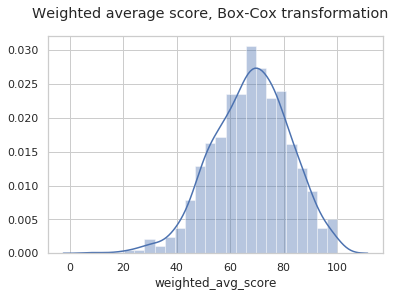

In [27]:
boxcox_weighted,_ = boxcox(student_df['weighted_avg_score'])

plt.suptitle("Weighted average score, Box-Cox transformation")
sns.distplot(student_df['weighted_avg_score'])
plt.show()

In [28]:
is_it_normal(boxcox_weighted)

Normality test statistics is 2.779859399071932 and p value is 0.24909281535666203


Again, better...?

## 3. Which variables seem related to the target variable (the newly created variable in the previous question)? If our goal is to explain the determinants of success in exams, which variables in our dataset might be useful?

So, which of the categorical variables are associated with the highest weighted average test scores?

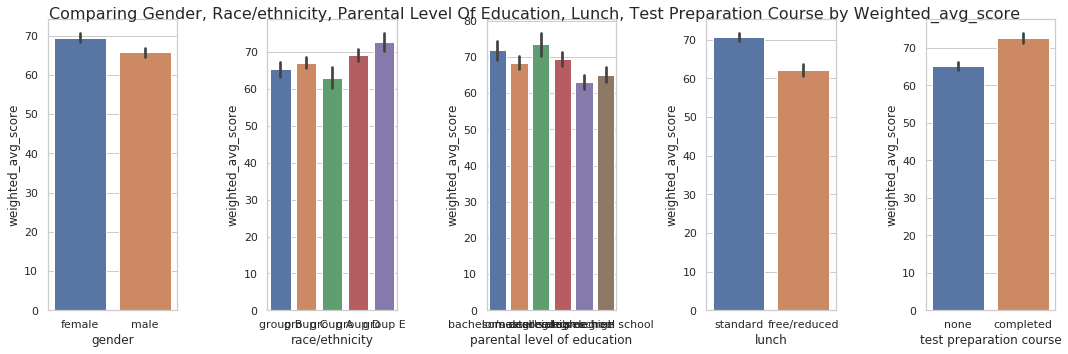

In [54]:
barplot_comparison(student_df,
                   'weighted_avg_score',
                   ['gender','race/ethnicity','parental level of education','lunch','test preparation course'],
                  nostats=True)

__The highest weighted average scores are associated to these variables/means/counts:__

* __Master's Degree__ of the parental level of education category (73.598870, 59 students)
* __Group E__ of the race/ethnicity category (72.752381, 140 students)
* __Completed a test preparation course__ (72.669460, 358 students)
* __Bachelor's Degree__ of the parental level of education category (71.923729, 118 students)
* __Standard lunch__ (70.837209, 645 students)
* __Women__ (69.569498, 518 students)

In terms of importance to the target variable, I would rank the categorical variables like this:
1. Students who __completed a test preparation course__ represent the third-highest test score among these five, and the third-largest group, with 358 students.

2. Students who eat a __standard lunch__ are the largest group by far with 645 students, though their average test score only ranks fifth of the top five. Also note that the kind of lunch is probably not as important as whatever factors are driving the kind of lunch students are eating (I guessed parental level of education are a factor in the last module's exercises).

3. __Parental level of education__ is probably the next most important factor, having two of the top five average scores (first and fourth), and a total of 177 students.

4. __Women__--gender seems to be significant, having the second-largest group (518 students) and holding the sixth-highest average test score.

5. __Race/ethnicity, group E__ has the second highest test score, but this group only has 140 students.


In [61]:
student_df.groupby('race/ethnicity').mean()

,math score,reading score,writing score,weighted_avg_score
race/ethnicity,,,,
group A,61.629213,64.674157,62.674157,62.992509
group B,63.452632,67.352632,65.600000,65.468421
group C,64.463950,69.103448,67.827586,67.131662
group D,67.362595,70.030534,70.145038,69.179389
group E,73.821429,73.028571,71.407143,72.752381


In [66]:
student_df.groupby('race/ethnicity').count()

,gender,parental level of education,lunch,test preparation course,math score,reading score,writing score,weighted_avg_score
race/ethnicity,,,,,,,,
group A,89,89,89,89,89,89,89,89
group B,190,190,190,190,190,190,190,190
group C,319,319,319,319,319,319,319,319
group D,262,262,262,262,262,262,262,262
group E,140,140,140,140,140,140,140,140


In [63]:
student_df.groupby('parental level of education').mean()

,math score,reading score,writing score,weighted_avg_score
parental level of education,,,,
associate's degree,67.882883,70.927928,69.896396,69.569069
bachelor's degree,69.389831,73.000000,73.381356,71.923729
high school,62.137755,64.704082,62.448980,63.096939
master's degree,69.745763,75.372881,75.677966,73.598870
some college,67.128319,69.460177,68.840708,68.476401
some high school,63.497207,66.938547,64.888268,65.108008


In [67]:
student_df.groupby('parental level of education').count()

,gender,race/ethnicity,lunch,test preparation course,math score,reading score,writing score,weighted_avg_score
parental level of education,,,,,,,,
associate's degree,222,222,222,222,222,222,222,222
bachelor's degree,118,118,118,118,118,118,118,118
high school,196,196,196,196,196,196,196,196
master's degree,59,59,59,59,59,59,59,59
some college,226,226,226,226,226,226,226,226
some high school,179,179,179,179,179,179,179,179


In [60]:
student_df.groupby('test preparation course').mean()

,math score,reading score,writing score,weighted_avg_score
test preparation course,,,,
completed,69.695531,73.893855,74.418994,72.669460
none,64.077882,66.534268,64.504673,65.038941


In [68]:
student_df.groupby('test preparation course').count()

,gender,race/ethnicity,parental level of education,lunch,math score,reading score,writing score,weighted_avg_score
test preparation course,,,,,,,,
completed,358,358,358,358,358,358,358,358
none,642,642,642,642,642,642,642,642


In [64]:
student_df.groupby('gender').mean()

,math score,reading score,writing score,weighted_avg_score
gender,,,,
female,63.633205,72.608108,72.467181,69.569498
male,68.728216,65.473029,63.311203,65.837483


In [70]:
student_df.groupby('gender').count()

,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,weighted_avg_score
gender,,,,,,,,
female,518,518,518,518,518,518,518,518
male,482,482,482,482,482,482,482,482


In [65]:
student_df.groupby('lunch').mean()

,math score,reading score,writing score,weighted_avg_score
lunch,,,,
free/reduced,58.921127,64.653521,63.022535,62.199061
standard,70.034109,71.654264,70.823256,70.837209


In [69]:
student_df.groupby('lunch').count()

,gender,race/ethnicity,parental level of education,test preparation course,math score,reading score,writing score,weighted_avg_score
lunch,,,,,,,,
free/reduced,355,355,355,355,355,355,355,355
standard,645,645,645,645,645,645,645,645
